In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import os, math, time

In [2]:
from ePModelModHowell import ePModel
from wavesIIFs import *
from scipy import signal

In [3]:
%matplotlib inline

# Model Parameters

In [4]:
# Dendrite
C_dend      = 1.0e-2    # Dendritic membrane capacitance (F / m2)
rhom_dend   = 28.0e-1   # Dendritic membrane resistivity (Ohm m2)
rha_dend    = 1.5       # Dendritic membrane internal resistivity (Ohm m)
d_dend      = 1.2e-6    # Dendritic cable diameter (m)
L_dend      = 700.0e-6  # Dendritic cable length (m)

# Soma (here we take the same values for the soma and dendrite as in Rattay 1999)
C_soma      = 1.0e-2    # Somatic membrane capacitance (F / m2)
rhom_soma   = 28.0e-1   # Somatic membrane resistivity (Ohm m2)
d_soma      = 10e-6     # Soma diameter (m)

# extraceullular electric field
E_freq      = 10        # Field frequency (Hz)
E_amp       = 1.        # Field amplitude (V/m)
E_tDelay    = 250       # delay time for E-field (ms)

# time
duration    = 10e3 + E_tDelay # Simulation duration (ms)
dt          = 0.1   # Integration time in ms

# membrane voltage
V0      = 0.     # Base membrane voltage in this absence of input (mV)
VT      = 10.    # Spike threshold (mV)
T_ref   = 1.5    # Refractory time after each spike (ms) 

# noisy stimuli at soma and dendrite
OUNoise_soma_mean   = 6.1e-3 # Mean of the noisy somatic input (nA)
OUNoise_soma_std    = 5e-3  # Standard deviation of the Ornstein-Uhlenbeck process for the somatic input (nA)
OUNoise_dend_mean   = 0 # Mean of the noisy dendritic input (nA)
OUNoise_dend_std    = OUNoise_soma_std  # Standard deviation of the Ornstein-Uhlenbeck process for the dendritic input (nA)

# Extended point neuron model (eP)

## Initialize the eP model

In [5]:
eP = ePModel()

## eP model in response to fluctuating input at the soma and distal dendrite

In this section we simuate the eP neuron model subject to noisy somatic and distal dendritic input currents given by Ornstein-Uhlenbeck processes. The BS model is not included here.

In [6]:
@numba.njit
def generateOUNoise(t_s,Tau_OU_s, stdOU):
    '''
    This function generates an Ornstein-Uhlenbeck process realization

    Parameters:
        :param t_s:         Time samples for the OU process
        :param Tau_OU_s:    OU process time constant
        :param stdOU:       OU process standard deviation
    
    :returns OUNoise:       OU process realization
    '''
    OUNoise = np.zeros_like(t_s)

    if Tau_OU_s == 0.:
        for i in range(len(OUNoise)):
            OUNoise[i] = stdOU * np.random.randn()
        return OUNoise

    OUNoise = np.zeros_like(t_s)
    dt  = t_s[1] - t_s[0]
    D   = 2 * stdOU * stdOU / Tau_OU_s
    mu  = np.exp(-dt/Tau_OU_s)
    amp = stdOU * np.sqrt( (1-np.exp(-2*dt/Tau_OU_s)) )

    for i in range(len(t_s) - 1):
        OUNoise[i+1]= mu * OUNoise[i] + amp * np.random.randn()

    return OUNoise

In [7]:
# time vector
t = np.arange(0,duration,dt)

In [8]:
# noise input vectors
OUNoise_soma = generateOUNoise(t*1e-3,0.5e-3,OUNoise_soma_std) + OUNoise_soma_mean
OUNoise_dend = generateOUNoise(t*1e-3,0.5e-3,OUNoise_dend_std) + OUNoise_dend_mean

I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(t*1e-3,OUNoise_soma*1e-9,0)
I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(t*1e-3,OUNoise_dend*1e-9,0)
I_ext_eP = I_soma_eP + I_dend_eP

In [30]:
# Compute equivalent current for DC pulse
pWidth = duration - E_tDelay # ms

# OPTION 1, RECTANGULAR PULSE
# EStim = rectPulse(amp=1, pw=pWidth, tDelay=E_tDelay*1e-3, t=t*1e-3)

# OPTION 2, INTERFERENCE WAVE
# w1 = inf2Wave(amp=E_amp, relStrBase=1, fBase=10, fBeat=0, tDelay=E_tDelay*1e-3, t=t*1e-3)
# w2 = inf2Wave(amp=E_amp, relStrBase=1, fBase=1e3, fBeat=0, tDelay=E_tDelay*1e-3, t=t*1e-3)
# EStim =  np.multiply(w1, abs(w2))
EStim =  inf2Wave(amp=E_amp, relStrBase=1, fBase=10, fBeat=0, tDelay=E_tDelay*1e-3, t=t*1e-3)

# OPTION 3, PULSE TRAIN
# pw = 10e-3 # [s]
# fStim = 10
# yBase = -0.5 * signal.sawtooth(2 * np.pi * fStim * (t - E_tDelay)*1e-3, width=0.9999) + 0.5
# EStim = np.copy(yBase)
# ckPos = (yBase >= (0.75 - pw*fStim/2)) & (yBase < (0.75 + pw*fStim/2))
# ckNeg = (yBase >= (0.25 - pw*fStim/2)) & (yBase < (0.25 + pw*fStim/2))
# EStim[ckPos] = 10/3-1
# EStim[ckNeg]  = 0
# EStim[(t < E_tDelay) | ~(ckPos | ckNeg)]  = 0
# EDC = 1

# OPTION 4, CUSTOM
# EStim = np.zeros(t.shape)
# EStim[(t > 1e3) & (t <= 3e3)] = 1
# EStim[(t > 4e3) & (t <= 5e3)] = -1
# EStim[(t > 6e3) & (t <= 7e3)] = 1
# EStim[(t > 8.5e3) & (t <= 9.5e3)] = -1

IEStim = eP.computeEquivIinputfromBSEext(t_BS=t*1e-3, Eext_BS=(EStim+EDC), V0=0)

(0.2, 0.4)

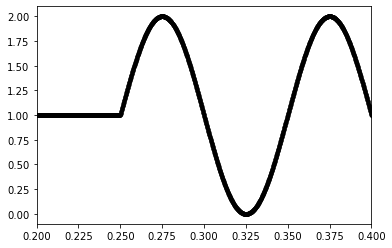

In [31]:
plt.plot(t*1e-3, EStim+EDC, 'k.-')
plt.xlim([0.2, 0.4])

In [11]:
# Run the eP model
scaleE = -3 #2.5 vs 1.8 E-field vector is unit solution (i.e., @ 1 V/m)
t_eP, V_eP = eP.runSim(t=t*1e-3, IE=scaleE*IEStim, V0=0, I_ext=I_ext_eP)

8.620775077041985
8.585533376260999


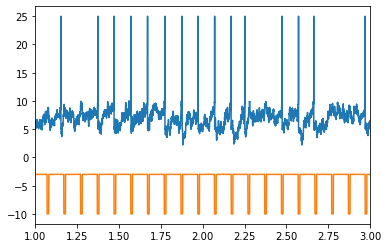

In [12]:
plt.plot(t_eP, 1e3*V_eP)
# plt.plot(t_eP, scaleE*IEStim*1e12)
plt.plot(t_eP, scaleE*(EStim+EDC))
plt.xlim([1, 3])
subIndx = (t_eP > 0)
VSub = V_eP[subIndx]
tSub = t_eP[subIndx]
sTimes = t_eP[np.nonzero(-1e3*np.diff(VSub) >= 4.9)]
print(1 / np.mean(np.diff(sTimes))) # [Hz]
print(np.count_nonzero(-1e3*np.diff(VSub) >= 4.9) / (tSub[-1] - tSub[0])) # [Hz]
# MExpStim = np.concatenate((t_eP, EStim, 1e3*V_eP), axis=0).reshape(3, t.size).transpose()
# np.savetxt('ptNeuron_C1time_C2E_C3Vm.txt', MExpStim)

In [65]:
# ANALYSIS - one raster for one waveform for at set E strength

numTrials = 100

dt = 0.1

# time vector
timDur = 10e3
t = np.arange(0, timDur, dt) # [ms]
numTimePts = t.size

# P-tDCS
# pWidth = timDur - E_tDelay # ms
# EUnit = rectPulse(amp=1, pw=pWidth, tDelay=E_tDelay*1e-3, t=t*1e-3)
# Ring Modulation (RM) only
# E1 =  inf2Wave(amp=E_amp, relStrBase=1, fBase=10, fBeat=0, tDelay=E_tDelay*1e-3, t=t*1e-3)
# E2 =  inf2Wave(amp=E_amp, relStrBase=1, fBase=1e3, fBeat=0, tDelay=E_tDelay*1e-3, t=t*1e-3)
# EUnit =  np.multiply(E1, np.absolute(E2))
# AM and conventional
EUnit =  inf2Wave(amp=E_amp, relStrBase=1, fBase=20, fBeat=0, tDelay=E_tDelay*1e-3, t=t*1e-3)

# scale E and covert to equivalent current
scaleE = -2 # flip polarity for anode
IEStim = eP.computeEquivIinputfromBSEext(t_BS=t*1e-3, Eext_BS=scaleE*EUnit, V0=0)

# matrix to record vm of all trials
vmAll = np.zeros((numTrials, numTimePts))
trialIDs = []
spikeTimes = []
for k in range(numTrials):
    
    # generate input noise / trial
    OUNoise_soma = generateOUNoise(t*1e-3,0.5e-3,OUNoise_soma_std) + OUNoise_soma_mean
    OUNoise_dend = generateOUNoise(t*1e-3,0.5e-3,OUNoise_dend_std) + OUNoise_dend_mean
    I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(t*1e-3,OUNoise_soma*1e-9,0)
    I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(t*1e-3,OUNoise_dend*1e-9,0)
    I_ext_eP = I_soma_eP + I_dend_eP
    
    # run simulation (sim time in s)
    t_eP1, V_eP0 = eP.runSim(t=t*1e-3, IE=IEStim, V0=0, I_ext=I_ext_eP)
    vmAll[k, :] = V_eP0
    
    # get spike times and respective trial ID
    spikes_k = 1e-3 * dt * (np.nonzero(-1e3*np.diff(vmAll[k, :]) >= 4.9)[0] - 1)
    ID_k = (k+1) * np.ones(spikes_k.shape)
    
    # cumulate spike times and trial IDs
    trialIDs = np.append(trialIDs, ID_k, axis=0)
    spikeTimes = np.append(spikeTimes, spikes_k, axis=0)

totNumSpikes = spikeTimes.size
Mspikes = np.concatenate((trialIDs, spikeTimes), axis=0).reshape(2, totNumSpikes).transpose()
print('done')

done


In [66]:
totNumSpikes / 10 / 100

2.296

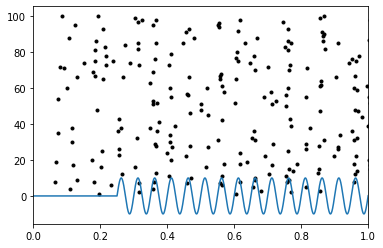

In [68]:
# quality control before saving
plt.plot(Mspikes[:, 1], Mspikes[:, 0], 'k.')
plt.plot(t*1E-3, 10*EUnit)
plt.xlim([0,1])
np.savetxt('spikes_100PtNrns_tDCS2mA_anode2p42pm.txt', Mspikes) 
# np.savetxt('spikes_100PtNrns_noStim.txt', Mspikes) 
# np.savetxt('spikes_100PtNrns_10kHz_tACS9p3mA_anode5p4Vpm.txt', Mspikes) 
# np.savetxt('spikes_100PtNrns_1kHz14Hz_tACS6p8mA_anode4p6Vpm.txt', Mspikes) 

In [99]:
print(int((20-0)/0.5)+1)
print(np.linspace(0, 20, 40+1))

41
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20. ]


In [114]:
# ANALYSIS - spike rate for range of E values

# time vector (for all simulations)
timDur = 10e3
t = np.arange(0, timDur, dt) # [ms]
numTimePts = t.size
stimTime = 1e-3 * (timDur - E_tDelay) # [s]

# number of trials per E value
numTrials = 100

# stimulation frequency
fStim = 10 # [Hz]
fMod = 1e3 # ""

# sinusoidal waveform
# w1 = inf2Wave(amp=E_amp, relStrBase=1, fBase=fStim, fBeat=0, tDelay=E_tDelay*1e-3, t=t*1e-3)
# w2 = inf2Wave(amp=E_amp, relStrBase=1, fBase=fMod, fBeat=0, tDelay=E_tDelay*1e-3, t=t*1e-3)
# EUnit =  np.multiply(w1, abs(w2))
# EUnit =  inf2Wave(amp=E_amp, relStrBase=1, fBase=fMod, fBeat=fStim, tDelay=E_tDelay*1e-3, t=t*1e-3)

# pulsatile waveform
E_DC = -3
pw = 10e-3 # [s]
fStim = 10
yBase = -0.5 * signal.sawtooth(2 * np.pi * fStim * (t - E_tDelay)*1e-3, width=0.9999) + 0.5
EUnit = np.copy(yBase)
ckPos = (yBase >= (0.75 - pw*fStim/2)) & (yBase < (0.75 + pw*fStim/2))
ckNeg = (yBase >= (0.25 - pw*fStim/2)) & (yBase < (0.25 + pw*fStim/2))
EUnit[ckPos] = -1 # polarity flipped because -1 / 1 => anodic / cathodic
EUnit[ckNeg]  = 0 # (0 / 1 => monophasic / biphasic)
EUnit[(t < E_tDelay) | ~(ckPos | ckNeg)]  = 0
# IEUnit = eP.computeEquivIinputfromBSEext(t_BS=t*1e-3, Eext_BS=EUnit, V0=0)

# define E magnitudes [V/m]
Emin = 0
Emax = 20
dE = 0.5
E_value = np.linspace(0, Emax, int((Emax-Emin) / dE)+1)
numE = E_value.size

# pre-allocate matrices to hold firing rates for all cases
spikeRate = np.zeros((numTrials, numE))

all_E = []
all_trialID = []
all_spikes = []
for ii in range(numE):        
    
    for jj in range(numTrials):
        
        # 1. generate somal/dendritic input for this simulation
        OUNoise_soma = generateOUNoise(t*1e-3,0.5e-3,OUNoise_soma_std) + OUNoise_soma_mean
        OUNoise_dend = generateOUNoise(t*1e-3,0.5e-3,OUNoise_dend_std) + OUNoise_dend_mean
        I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(t*1e-3,OUNoise_soma*1e-9,0)
        I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(t*1e-3,OUNoise_dend*1e-9,0)
        I_ext_eP = I_soma_eP + I_dend_eP
                
        # 2. run simulations for increasing E-field magnitudes
        IEStim = eP.computeEquivIinputfromBSEext(t_BS=t*1e-3, Eext_BS=(E_value[ii] * EUnit + E_DC), V0=0)
        trash, V_E = eP.runSim(t=t*1e-3, IE=IEStim, V0=0, I_ext=I_ext_eP)
#         trash, V_E = eP.runSim(t=t*1e-3, IE=E_value[ii]*IEUnit, V0=0, I_ext=I_ext_eP)
        
        # 3. calculate average firing rate
        spikeRate[jj, ii] = np.count_nonzero(-1e3*np.diff(V_E) >= 4.9) / stimTime # [Hz]
        
        # get spike times and respective trial ID
        spikes_j = 1e-3 * dt * (np.nonzero(-1e3*np.diff(V_E) >= 4.9)[0] - 1)
        trialID_j = (jj + 1) * np.ones(spikes_j.shape)
        E_j = E_value[ii] * np.ones(spikes_j.shape)

        # cumulate spike times and trial IDs
        all_E = np.append(all_E, E_j, axis=0)
        all_trialID = np.append(all_trialID, trialID_j, axis=0)
        all_spikes = np.append(all_spikes, spikes_j, axis=0)

totNumSpikes = all_spikes.size
M_spikes = np.concatenate((all_E, all_trialID, all_spikes), axis=0).reshape(3, totNumSpikes).transpose() 
print("Done!")

Done!


[ 5.41128205  5.55179487  5.6974359   5.86871795  6.08307692  6.22564103
  6.37230769  6.68307692  7.01230769  7.36512821  7.62461538  7.94461538
  8.31692308  8.59076923  9.          9.33230769  9.64717949  9.99384615
 10.14358974 10.39179487 10.64717949 10.84102564 11.01641026 11.18769231
 11.30564103 11.39589744 11.54974359 11.54769231 11.62564103 11.68102564
 11.79282051 11.8        11.74666667 11.75282051 11.76717949 11.88717949
 11.78666667 11.81641026 11.91282051 11.82769231 11.96512821]


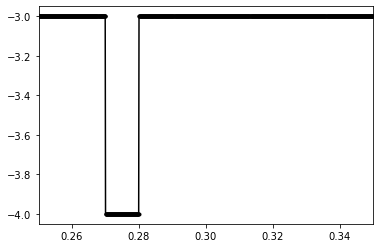

In [116]:
plt.plot(t*1e-3, EUnit + E_DC, 'k.-')
plt.xlim([0.25, 0.35])
print(np.mean(spikeRate, axis=0))
# np.savetxt('spikeRate_tACS_10Hz_vsEMag.txt', spikeRate)
# np.savetxt('spikeTimes_RMtACS_base1kHz_beat10Hz_vsEMag.txt', M_spikes)
# np.savetxt('spikeTimes_tACS_10Hz_vsEMag.txt', M_spikes)
np.savetxt('spikeTimes_tDCS3mA_tPCS_10Hz10msMP_EMag.txt', M_spikes)

In [ ]:
# ANALYSIS - pulsed current stimulation

# global parameters
numTrials = 100
timeDur = 10e3

# simulation parameters
polarity = 'anode' # {anode, cathode}
duty = 0.9 # [0.1, 0.25, 0.5, 0.75, 0.9] (0 <= duty <= 1)
EMag = 3
simTag = polarity + "_" + str(EMag) + 'Vpm_duty' +  str.replace(str(duty), '.', 'p')

# define E-field dxn (-1/1 in/out w/r to scalp)
if polarity == 'cathode':
    EPol = 1 # default E direction is hyperpolarizing
else:
    EPol = -1

# define frequencies
freqVal = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1e3])
numFreq = freqVal.size

freqIDs = []
trialIDs = []
spikeTimes = []
for ii in range(numFreq):
    
    # define time vector for each frequency    
    if freqVal[ii]/duty > 500:
        dt = 0.1/5
    else:
        dt = 0.1
    t = np.arange(0, timeDur, dt)
    
    # define stimulus
    yBase = -0.5 * signal.sawtooth(2 * np.pi * freqVal[ii] * (t - E_tDelay)*1e-3, width=0.9999) + 0.5
    EUnit = np.copy(yBase)
    EUnit[yBase >= (1-duty)] = 1
    EUnit[(yBase < (1-duty)) | (t < E_tDelay)]  = 0
    IEStim = eP.computeEquivIinputfromBSEext(t_BS=t*1e-3, Eext_BS=EPol*EMag*EUnit, V0=0)
    
    for k in range(numTrials):

        # generate input noise / trial
        OUNoise_soma = generateOUNoise(t*1e-3,0.5e-3,OUNoise_soma_std) + OUNoise_soma_mean
        OUNoise_dend = generateOUNoise(t*1e-3,0.5e-3,OUNoise_dend_std) + OUNoise_dend_mean
        I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(t*1e-3,OUNoise_soma*1e-9,0)
        I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(t*1e-3,OUNoise_dend*1e-9,0)
        I_ext_eP = I_soma_eP + I_dend_eP

        # run simulation (sim time in s)
        t_eP1, V_eP0 = eP.runSim(t=t*1e-3, IE=IEStim, V0=0, I_ext=I_ext_eP)

        # get spike times and respective trial ID
        spikes_k = 1e-3 * dt * (np.nonzero(-1e3*np.diff(V_eP0) >= 4.9)[0] - 1)
        ID_k = (k+1) * np.ones(spikes_k.shape)
        f_k = freqVal[ii] * np.ones(spikes_k.shape)

        # cumulate spike times and trial IDs
        freqIDs = np.append(freqIDs, f_k, axis=0)
        trialIDs = np.append(trialIDs, ID_k, axis=0)
        spikeTimes = np.append(spikeTimes, spikes_k, axis=0)
    
totNumSpikes = spikeTimes.size
Mspikes = np.concatenate((freqIDs, trialIDs, spikeTimes), axis=0).reshape(3, totNumSpikes).transpose()    

In [ ]:
# quality control before saving
indxf = Mspikes[:,0] == 100
plt.plot(Mspikes[indxf, 2], Mspikes[indxf, 1], 'k.')
plt.plot(t*1E-3, EUnit)
plt.xlim([0, 10])
fName = 'spikesVfreq_100PtNrns_' + simTag + '.txt'
fName
# np.savetxt(fName, Mspikes) 

In [ ]:
plt.plot(tVec,EIntReal)
plt.xlim([0.25,0.255])

In [ ]:
# np.savetxt('fFire_trialsRows_EmagCols_EDC_Cath.txt', fFireDC)
# np.savetxt('fFire_trialsRows_EmagCols_EIntReal10x10usRepeating_Cath.txt', fFireIxn)

In [ ]:
# plt.figure(figsize=(12.,8.))
# plt.subplot(2, 1, 1)
# plt.plot(t_eP,V_eP*1e3)
# plt.ylabel('Somatic membrane voltage (mV)', fontsize=12)
# plt.xlabel('Time (s)', fontsize=12)
# plt.xlim([0,2])
# plt.title('Response of the eP neuron to noisy input at the soma and distal dendrite', fontsize=16)
# plt.subplot(2, 1, 2)
# plt.plot(t_eP,EStim)
# plt.xlim([0,2])

# # Note that the membrane voltage here denotes the difference to the membrane voltage at rest
# countSpikes = np.count_nonzero(-1e3*np.diff(V_eP) >= 4.9)
# print(countSpikes, countSpikes / duration / 1e-3)

In [ ]:
# # PLOT - show example of somatic and dendritic input currents
# indxSamp = t*1e-3 <= 0.1
# numPtsSamp = np.sum(indxSamp)
# MInputsNoise = np.concatenate((t[indxSamp]*1e-3, I_soma_eP[indxSamp]*1e12, I_dend_eP[indxSamp]*1e12), axis=0)\
# .reshape((3, numPtsSamp)).transpose()
# print(MInputsNoise.shape)
# plt.subplot(1, 2, 1)
# plt.plot(MInputsNoise[:, 0], MInputsNoise[:, 1], 'b')
# plt.subplot(1, 2, 2)
# plt.plot(MInputsNoise[:, 0], MInputsNoise[:, 2], 'r')
# # np.savetxt('ptNeuronInputs_time_IsomaDendPicoAmp.txt', MInputsNoise)

In [ ]:
# # PLOT - show example of membrane voltage w/ and w/o application of E-field
# indxSamp = t*1e-3 <= 2
# numPtsSamp = np.sum(indxSamp)
# Moutput = np.concatenate((t[indxSamp]*1e-3, scaleE*EStim[indxSamp], V_eP[indxSamp]*1e3), axis=0)\
# .reshape((3, numPtsSamp)).transpose()
# plt.subplot(2, 1, 1)
# plt.plot(Moutput[:, 0], Moutput[:, 1], 'b')
# plt.subplot(2, 1, 2)
# plt.plot(Moutput[:, 0], Moutput[:, 2], 'r')
# # np.savetxt('ptNeuronOutput_time_noEField_VmMilliVolt.txt', Moutput)

In [ ]:
# # ANALYSIS - IF-tACS, polarization vs. frequency and magnitude of E-field

# # define frequency values to analyze (Hz)
# EfreqValues = np.array([1, 2, 5, 10, 20, 50, 100, 1e3, 2e3, 5e3, 10e3])
# numEfreq = EfreqValues.size
# diffVmMax_freq = np.zeros(EfreqValues.shape)

# # define E-field magnitudes to analyze (V/m)
# EmagValues = np.linspace(0, 10, 11)
# numEmag = EmagValues.size
# diffVmMax_mag = np.zeros(EmagValues.shape)

# # two different time vectors depending on frequency
# t1 = np.arange(0, 1e3, dt)
# t2 = np.arange(0, 1e3, dt/10)

# # analyze voltage deviation vs. frequency
# for k in range(numEfreq):
    
#     # pick time resolution based on stimulation frequency
#     if(EfreqValues[k] <= 1e3):
#         tVec = t1*1e-3
#     else:
#         tVec = t2*1e-3

#     # define E stimulus and run simulation
#     Ek =  inf2Wave(amp=1, relStrBase=1, fBase=EfreqValues[k], fBeat=0, tDelay=0, t=tVec)
#     IEk = eP.computeEquivIinputfromBSEext(t_BS=tVec, Eext_BS=Ek, V0=0)
#     t_eP, V_eP = eP.runSim(t=tVec, IE=IEk, V0=0, I_ext=0*I_ext_eP)
    
#     diffVmMax_freq[k] = 1e3 * np.max(V_eP)

# # analyze voltage deviation vs. magnitude
# # NOTE: chose 10 Hz because min. impedance at this value
# tVec = t1*1e-3
# Ek =  inf2Wave(amp=1, relStrBase=1, fBase=10, fBeat=0, tDelay=0, t=tVec) # unit sln. (scalable)
# for k in range(numEmag):

#     # define E stimulus and run simulation    
#     IEk = eP.computeEquivIinputfromBSEext(t_BS=tVec, Eext_BS=EmagValues[k]*Ek, V0=0)
#     t_eP, V_eP = eP.runSim(t=tVec, IE=IEk, V0=0, I_ext=0*I_ext_eP)
    
#     diffVmMax_mag[k] = 1e3 * np.max(V_eP)    

# M_VvsEfreq = np.concatenate((EfreqValues, diffVmMax_freq), axis=0).reshape((2, numEfreq)).transpose()
# M_VvsEmag = np.concatenate((EmagValues, diffVmMax_mag), axis=0).reshape((2, numEmag)).transpose()
# plt.subplot(1, 2, 1)
# plt.semilogx(M_VvsEfreq[:, 0], M_VvsEfreq[:, 1], 'b')
# plt.subplot(1, 2, 2)
# plt.plot(M_VvsEmag[:, 0], M_VvsEmag[:, 1], 'k')
# # np.savetxt('ptNeuron_delVmMax_VS_Efreq_Emag1.txt', M_VvsEfreq)
# # np.savetxt('ptNeuron_delVmMax_VS_Emag_Efreq10.txt', M_VvsEmag)  

In [ ]:
# # ANALYSIS - IF-tACS, effect of int. E-field on subthresh. membrane polarization

# # define base/carrier frequencies to analyze
# fBaseVal = np.array([100, 1e3, 1e4])
# numfBaseVal = fBaseVal.size

# # define beat frequencies to analyze
# fBeatVal = np.array([0, 1, 2, 5, 10, 20, 50, 100])
# numfBeatVal = fBeatVal.size

# # pre-allocate
# diffVmMax_int = np.zeros((numfBeatVal, numfBaseVal))
# tVec = 1e-3 * np.arange(0, 1e3, dt/10) # [s]

# for ii in range(numfBeatVal):
#     for jj in range(numfBaseVal):
        
#         # define int. E-field stimulus
#         Eij =  inf2Wave(amp=1, relStrBase=1, fBase=fBaseVal[jj], fBeat=fBeatVal[ii], tDelay=0, t=tVec)
#         IEij = eP.computeEquivIinputfromBSEext(t_BS=tVec, Eext_BS=Eij, V0=0)
        
#         # run simulation
#         t_eP, V_eP = eP.runSim(t=tVec, IE=IEij, V0=0, I_ext=0*I_ext_eP)
        
#         # calculate polarization
#         diffVmMax_int[ii, jj] = 1e3 * np.max(V_eP)
        
# np.savetxt('ptNeuron_delVmMax_unitEint_fbeatRows_fBaseCols.txt', diffVmMax_int)
# np.savetxt('unitEint_fBeatValues.txt', fBeatVal)
# np.savetxt('unitEint_fBaseValues.txt', fBaseVal)       

In [ ]:
# # PLOT - IF-tACS, rastor of spike timing when E-field is on and off

# numTrials = 100

# # temporal parameters
# delStim = 10 # duration of stimulus [s]
# totSimTime = 20 # total simulation time [s]
# tVec = 1e-3 * np.arange(0, totSimTime*1e3, dt/10) # dt in [ms], time in [s]
# numTimePts = tVec.size

# # test stimulus: constant freq., 10 Hz, 4 V/m
# Etest =  inf2Wave(amp=4, relStrBase=1, fBase=10e3, fBeat=10, tDelay=delStim, t=tVec) # unit sln. (scalable)
# IEtest = eP.computeEquivIinputfromBSEext(t_BS=tVec, Eext_BS=Etest, V0=0)

# # matrix to record vm of all trials
# vmAll = np.zeros((numTrials, numTimePts))
# trialIDs = []
# spikeTimes = []
# for k in range(numTrials):
    
#     # generate basal input noise
#     OUNoise_soma = generateOUNoise(tVec,0.5e-3,OUNoise_soma_std) + OUNoise_soma_mean
#     OUNoise_dend = generateOUNoise(tVec,0.5e-3,OUNoise_dend_std) + OUNoise_dend_mean
#     I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(tVec,OUNoise_soma*1e-9,0)
#     I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(tVec,OUNoise_dend*1e-9,0)
#     I_ext_eP = I_soma_eP + I_dend_eP
    
#     # run simulation
#     t_eP10, V_eP10 = eP.runSim(t=tVec, IE=IEtest, V0=0, I_ext=I_ext_eP)
#     vmAll[k, :] = V_eP10.transpose()
    
#     # get spike times and respective trial ID
#     spikes_k = 1e-3 * dt * (np.nonzero(-1e3*np.diff(vmAll[k, :]) >= 4.9)[0] - 1)
#     ID_k = (k+1) * np.ones(spikes_k.shape)
    
#     # cumulate spike times and trial IDs
#     trialIDs = np.append(trialIDs, ID_k, axis=0)
#     spikeTimes = np.append(spikeTimes, spikes_k, axis=0)

# totNumSpikes = spikeTimes.size
# Mspikes = np.concatenate((trialIDs, spikeTimes), axis=0).reshape(2, totNumSpikes).transpose()
# np.savetxt('pntNeuron_C1TrialC2SpikeTimes_IF-tACS-10HzBeat-10kHzBase-4Vpm.txt', Mspikes) 

In [ ]:
# ANALYSIS - IF-tACS or IS-tDCS, effect of int. E-field on firing rate

# define number of trials to try
numTrials = 100

# define E-field magnitudes to analyze (V/m)
EmagValues = np.linspace(0, 10, 11)
numEmag = EmagValues.size

# pre-allocate matrices to hold firing rates for all cases
fFire10 = np.zeros((numTrials, numEmag))
fFireInt = np.zeros((numTrials, numEmag))

# temporal parameters
delStim = 0.25 # time to delay stimulation [s]
durStim = 10 # time to deliver stimulation [s]
totTime = delStim + durStim # total simulation time [s]
tVec = 1e-3 * np.arange(0, totTime*1e3, dt) # dt in [ms], time in [s]

# unit AC stimulus
# E10Unit =  inf2Wave(amp=1, relStrBase=1, fBase=10, fBeat=0, tDelay=delStim, t=tVec) # unit sln. (scalable)
yBase = -0.5 * signal.sawtooth(2 * np.pi * 10 * (t - E_tDelay)*1e-3, width=0.99999999) + 0.5
E10Unit = np.copy(yBase)
E10Unit[yBase >= 0.9] = -1
E10Unit[(yBase < 0.9) | (t < E_tDelay)]  = 0
IE10Unit = eP.computeEquivIinputfromBSEext(t_BS=tVec, Eext_BS=E10Unit, V0=0)

# unit Int. stimulus
# - fBase = 1 kHz, fBeat = 10 Hz, perfect interference
EIntUnit =  inf2Wave(amp=1, relStrBase=1, fBase=100, fBeat=10, tDelay=delStim, t=tVec) # unit sln. (scalable)
# EIntUnit =  inf2Wave(amp=1, relStrBase=1, fBase=100, fBeat=10, tDelay=delStim, t=tVec) # unit sln. (scalable)
IEIntUnit = eP.computeEquivIinputfromBSEext(t_BS=tVec, Eext_BS=EIntUnit, V0=0)

for ii in range(numTrials):
    
    # 1. generate somal/dendritic input for this simulation
    OUNoise_soma = generateOUNoise(tVec,0.5e-3,OUNoise_soma_std) + OUNoise_soma_mean
    OUNoise_dend = generateOUNoise(tVec,0.5e-3,OUNoise_dend_std) + OUNoise_dend_mean
    I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(tVec,OUNoise_soma*1e-9,0)
    I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(tVec,OUNoise_dend*1e-9,0)
    I_ext_eP = I_soma_eP + I_dend_eP
    
    for jj in range(numEmag):
                
        # 2. run simulations for increasing E-field magnitudes
        t_eP10, V_eP10 = eP.runSim(t=tVec, IE=EmagValues[jj]*IE10Unit, V0=0, I_ext=I_ext_eP)
        t_ePInt, V_ePInt = eP.runSim(t=tVec, IE=EmagValues[jj]*IEIntUnit, V0=0, I_ext=I_ext_eP)
        
        # 3. calculate average firing rate
        fFire10[ii, jj] = np.count_nonzero(-1e3*np.diff(V_eP10) >= 4.9) / totTime # [Hz]
        fFireInt[ii, jj] = np.count_nonzero(-1e3*np.diff(V_ePInt) >= 4.9) / totTime # [Hz]

# np.savetxt('ptNeuron_fFire_trialsRows_EmagCols_E10Hz.txt', fFire10)
# np.savetxt('ptNeuron_fFire_trialsRows_EmagCols_EInt1kHzBase10HzBeat.txt', fFireInt)
# np.savetxt('fFire_EmagValues.txt', EmagValues)
# print(np.mean(fFire10, axis=0))

In [ ]:
print(np.mean(fFire10, axis=0))
print(np.mean(fFireInt, axis=0))
np.savetxt('ptNeuron_fFire_trialsRows_EmagCols_IF-tACS-100HzBase10HzBeat.txt', fFireInt)

In [ ]:
# indxSamp = tVec <= 2
# numPtsSamp = np.sum(indxSamp)

# ME10 = np.concatenate((tVec[indxSamp], E10Unit[indxSamp]), axis=0).reshape((2, numPtsSamp)).transpose()
# MEint = np.concatenate((tVec[indxSamp], EIntUnit[indxSamp]), axis=0).reshape((2, numPtsSamp)).transpose()

# np.savetxt('waveform_unitE10Hz.txt', ME10)
# np.savetxt('waveform_unitEInt1kHzBase10HzBeat.txt', MEint)